<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLatFIAN2020/blob/master/seminar13/MLatFIAN2020_seminar13_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational autoencoders (VAE)

In [ ]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
from tqdm import tqdm

from PIL import Image

In [ ]:
lfw = tfds.image_classification.LFW()
lfw.download_and_prepare()
ds = lfw.as_dataset()

In [ ]:
def get_img(x):
  return x['image'][80:-80,80:-80]

data = np.array([
  np.array(Image.fromarray(img.numpy()).resize((36, 36)))
  for img in tqdm(ds['train'].map(get_img))
])

In [ ]:
data.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(data[:25].reshape(5, 5, 36, 36, 3).transpose((0, 2, 1, 3, 4)).reshape(5 * 36, 5 * 36, 3));

### VAE in a nutshell

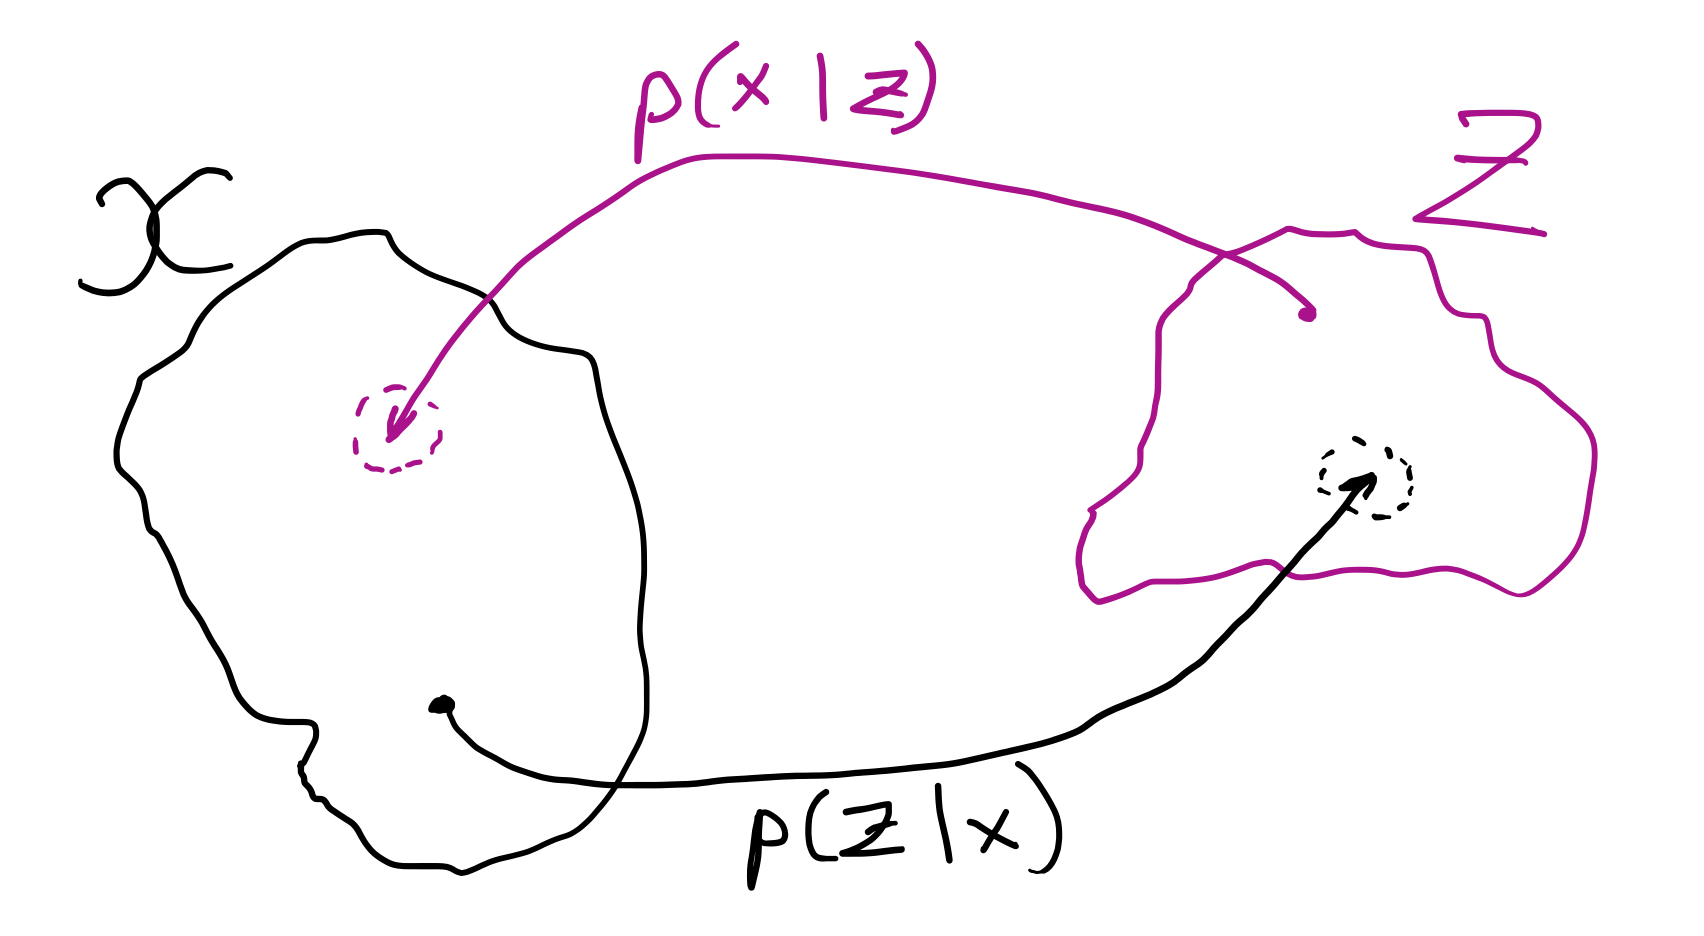

- We want to estimate the population distribution $p(x)$ given only samples $\{x_i\}$.

- We introduce latent variable $z$ with some fixed prior $p_z(z)$

- We model $p(x|z)$ with a (decoder) neural network $g_\theta(z)$, e.g.:
$$p_\theta(x|z)=\mathscr{N}(x|\mu=g_\theta(z),\Sigma=\sigma^2\mathbb{I})$$

- By this we effectively model $p(x)$ as $\int p_\theta(x|z)p_z(z)dz$

- To effectively train the model, we need the posterior on $z$: $p_\theta(z|x)$.
  - This is typically intractable, so we approximate it with another (encoder) neural network $f_\phi(x)$, e.g.:
$$q_\phi(z|x)=\mathscr{N}(z|\mu=f_\phi^\mu(x), \Sigma=f_\phi^{\sigma^2}(x)\mathbb{I})$$

- One can show, that both networks can be optimized simultaneously by maximizing the evidence lower bound (ELBO):
$$\text{ELBO}=\underset{x\sim p_{\text{data}}(x)}{\mathbb{E}}\left[\underset{z\sim q_{\phi}(z|x)}{\mathbb{E}}\log p_\theta(x|z) - D_{\text{KL}}(q_\phi(z|x)\Vert p_z(z))\right]$$

- The first term is log-likelihood - ensures the correct reconstruction. For a normal distribution this term will effectively reduce to negative MSE.

- The second term ensures that $\int p(z|x)p(x)dx=p_z(z)$

Note:
- Samples of $z\sim q_\phi(z|x)$ need to be differentiable wrt $\phi$ (can be achieved by the reparameterization trick)

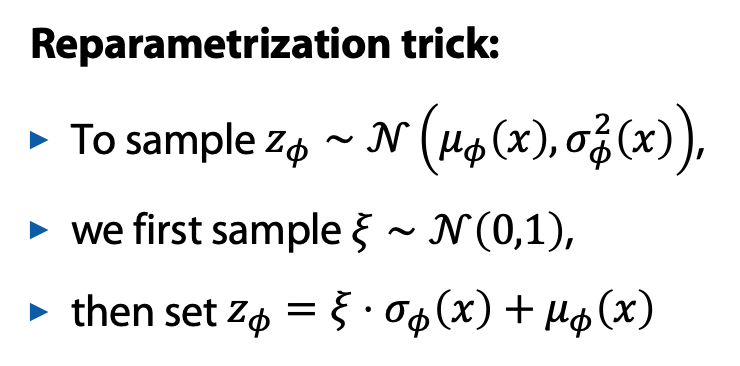

Let's preprocess the data:

In [ ]:
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

Define our neural networks (note that we need to separate outputs fo the encoder network - $\mu$ and $\sigma$):

In [ ]:
ll = tf.keras.layers

LATENT_DIM = 32

decoder = tf.keras.Sequential([
  ll.Dense(128, input_shape=(LATENT_DIM,), activation='relu'),
  ll.Dense(128, activation='relu'),
  ll.Dense(36 * 36 * 3, activation='sigmoid'),
  ll.Reshape((36, 36, 3)),
])

encoder_base = tf.keras.Sequential([
  ll.Reshape((36 * 36 * 3,), input_shape=(36, 36, 3)),
  ll.Dense(128, activation='relu'),
  ll.Dense(128, activation='relu')
])
latent_mu = ll.Dense(LATENT_DIM, activation=None)(encoder_base.output)
latent_logsigma = ll.Dense(LATENT_DIM, activation=None)(encoder_base.output)
encoder = tf.keras.Model(inputs=encoder_base.inputs, outputs=[latent_mu, latent_logsigma])

decoder.summary()
encoder.summary()

Defining the forward and backward passes:

In [ ]:
def gen_images(mu, logsigma):
  return decoder(tf.random.normal(shape=mu.shape) * tf.exp(logsigma) + mu)

# @tf.function decorator below compiles the function
# it decorates into a static graph. This improves the performance
# but there are some pitfalls one should be aware of when using it,
# check out https://www.tensorflow.org/guide/function
# for more details
@tf.function
def forward(batch):
  real = batch

  mu, logsigma = encoder(real)
  fake = gen_images(mu, logsigma)

  loss_mse = tf.reduce_sum((real - fake)**2, axis=(1, 2, 3))
  loss_KL = tf.reduce_sum(-logsigma + 0.5 * (mu**2 + tf.exp(2 * logsigma) - 1), axis=1)
  return tf.reduce_mean(loss_mse + 0.2 * loss_KL)

opt = tf.optimizers.Adam()

@tf.function
def backward(batch):
  with tf.GradientTape() as t:
    loss = forward(batch)
  grads = t.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
  opt.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
  return loss


In [ ]:
from IPython.display import clear_output
from tqdm import trange

Finally, training our model:

In [ ]:
BATCH_SIZE = 256

N_EPOCHS = 100

losses = []
for i_ep in range(N_EPOCHS):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
  epoch_loss = 0
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]
    epoch_loss += backward(batch).numpy() * len(batch)

  epoch_loss /= len(X_train)
  losses.append(epoch_loss)

  opt.learning_rate.assign(opt.learning_rate * 0.99)

  imgs = (gen_images(tf.zeros(shape=(25, LATENT_DIM)),
                     tf.zeros(shape=(25, LATENT_DIM))).numpy() * 255).astype('uint8')
  clear_output(wait=True)
  plt.figure(figsize=(12, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
  plt.subplot(1, 2, 2)
  plt.plot(losses)
  plt.yscale('log')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  print("Done with epoch #", i_ep)

Let's check the reconstruction quality:

In [ ]:
codes = encoder.predict(X_train)
reco = decoder.predict(codes[0])

In [ ]:
shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)

plt.figure(figsize=(12, 6), dpi=100)

plt.subplot(1, 2, 1)
plt.imshow(data[shuffle_ids][:25].reshape(5, 5, 36, 36, 3).transpose((0, 2, 1, 3, 4)).reshape(5 * 36, 5 * 36, 3));
plt.title('Train')

plt.subplot(1, 2, 2)
plt.imshow(reco[shuffle_ids][:25].reshape(5, 5, 36, 36, 3).transpose((0, 2, 1, 3, 4)).reshape(5 * 36, 5 * 36, 3));
plt.title('Reconstructed');